**AdaBoost композиция классификаторов** 

Евгений Борисов  <esborisov@sevsu.ru>

MachineLearning.ru : Алгоритм_AdaBoost   
http://www.machinelearning.ru/wiki/index.php?title=Алгоритм_AdaBoost

In [1]:
import numpy as np
from numpy import random as rng

import matplotlib.pyplot as plt

%precision 3
np.set_printoptions(precision=2)
np.set_printoptions(linewidth=110)
# np.get_printoptions()

# генерируем данные

(1024, 2)

(1024, 1)

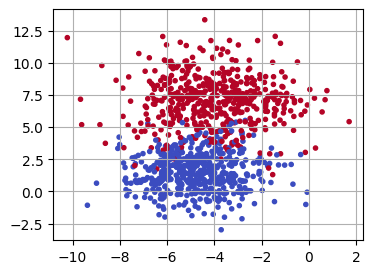

In [2]:
# from sklearn.datasets import make_moons
# X,target = make_moons(n_samples=n_samples, noise=.09)

from sklearn.datasets import make_blobs
X,target = make_blobs( n_samples=1024, centers=2,  cluster_std=[1.5, 1.8,] )

target = (2*target-1).reshape(-1,1)
display(X.shape, target.shape)

fig,ax = plt.subplots( figsize=(4,3),)
ax.scatter(x=X[:,0],y=X[:,1],c=target, marker='.', cmap='coolwarm')
ax.grid()

In [3]:
# нормируем данные

# from sklearn.preprocessing import MinMaxScaler
# X = MinMaxScaler([-1.0,1.0]).fit_transform(X)

# from sklearn.preprocessing   import StandardScaler
# X = StandardScaler().fit(X).transform(X)

# display( X.min(),np.mean(X),np.median(X),X.max() 

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, target_train, target_test = train_test_split(X,target,test_size=.5)
display( X_train.shape, X_test.shape, )

assert len(target_train) == len(X_train)
assert len(target_test) == len(X_test)

del X,target

(512, 2)

(512, 2)

# модель

## базовая модель

линейный классификатор

$$a(x,w) = sign \left( \sum\limits_{i=1} x_i \cdot w_i + w_0 \right) $$ 

In [5]:
class LinearClassifier:
    
    def __init__( self, weight=np.array([]) ):
        self._weight = weight
    
    def score(self,x):
        assert len(x)>0
        assert x.shape[1]==len(self._weight)
        return x.dot(self._weight)
    
    def predict(self,x): 
        return np.sign( self.score(x) ).astype(np.int8)
    
    @property
    def weight(self): return self._weight

    @weight.setter
    def weight(self,value): self._weight = value
        
    def weight_init(self,n,scale=1e-7): 
        self._weight = rng.normal(size=(n,1),scale=scale)
        return self
   
    def score_partial(self,x): # частные производные модели по её параметрам
        return x

In [34]:
# LinearClassifier( weight=rng.rand(X_train.shape[1],1) ).score(X_train)
# LinearClassifier( weight=rng.rand(X_train.shape[1],1) ).predict(X_train)

### обучаем базовую модель

взешенная функция потери AdaBoost

$$
Q(a) = \sum_{i=1}^{L} g_i \cdot \left[ y_i \cdot a(x_i) < 0 \right] 
$$

взешенный отступ (margin) показывает насколько далеко объект $x$ от разделяющей поверхности

$$
M( x,y,g ; w )=  g\cdot  y \cdot \langle x,w \rangle
$$

функция потери

$$ L = \log \left( 1 + \exp(-M) \right) $$

$$ \nabla L = - \frac{1}{1+\exp(-M)} $$

In [6]:
class WeightedLogLoss:

    @classmethod
    def score(cls,target,predicted,weight): 
        return np.log( 1 + np.exp( - cls._margin(target,predicted,weight) ) ).mean()
    
    @staticmethod
    def _margin(target,predicted,weight): return target*predicted*weight
    
    @staticmethod
    def partial( target, predicted, model_partial,weight ): # градиент функции потери
        margin = target*predicted*weight
        dl = -1./( np.exp( -margin )+1 )
        g = model_partial.T.dot( target*dl )
        g /= np.abs(g).max() # нормируем градиент
        return g

In [7]:
# model =  LinearClassifier( weight=rng.rand(X_train.shape[1],1) )
# s = model.score(X_train)
# p = model.score_partial(X_train)
# LogLoss().partial(target_train,s,p)

In [44]:
from sklearn.metrics import accuracy_score
from tqdm.auto import tqdm

class WeightedTrainGD:
    
    def __init__(self,model,loss):
        self._model = model
        self._loss = loss   
        self._lr = .1     
       
    def fit( self, X, target, xweight, lr=1e-2, n_epoch=512, acc_min=.99, ): 
        # n_epoch - максимальное число циклов обучения
        # acc_min - порог минимально допустимой погрешности модели
        self._lr = lr   # скорость обучения

        n_param = X.shape[1] # размер вектора признаков

        # инициализация параметров модели
        self._model.weight_init(n_param)

        # начальное значение ф-ции потери
        loss_history = [ self._loss.score(target,self._model.score(X),xweight) ]
        acc_history = [ accuracy_score(target,self._model.predict(X)) ]

        #for i in tqdm(range(n_epoch)): # цикл обучения
        for i in range(n_epoch): # цикл обучения
            self._fit_epoch(X,target,xweight) # корректируем веса модели
            loss_history.append(  self._loss.score(target,self._model.score(X),xweight) ) # считаем значение ф-ции потери
            acc_history.append( accuracy_score(target,self._model.predict(X)) )

            if acc_history[-1] > acc_min: # проверяем достижение минимального порога погрешности модели
                acc = acc_history[-1]
                print(f'step {i+1}/{n_epoch}: acc {acc:.3f}, threshold {acc_min:.3f} reached\n')  
                break
                
        return (acc_history,loss_history), self._model
    
    @property
    def model(self): return self._model
    
    def _fit_epoch(self,X,target,xweight):
        # градиент функции потери, изменение весов
        g = self._loss.partial(target,self._model.score(X),self._model.score_partial(X),xweight ) 
        self._weight_adjust(g) # корректируем параметры    
        return self
        
    def _weight_adjust(self,g):
        self._model.weight = self._model.weight - self._lr*g   # корректируем параметры
        return self
        

In [45]:
(acc_history,loss_history), model = WeightedTrainGD(
        model=LinearClassifier(),
        loss=WeightedLogLoss()
    ).fit( 
        X=X_train,
        target=target_train,
        xweight=np.ones(shape=(X_train.shape[0],1))/X_train.shape[0]
    )

              precision    recall  f1-score   support

          -1       1.00      0.30      0.47       253
           1       0.60      1.00      0.75       259

    accuracy                           0.66       512
   macro avg       0.80      0.65      0.61       512
weighted avg       0.80      0.66      0.61       512



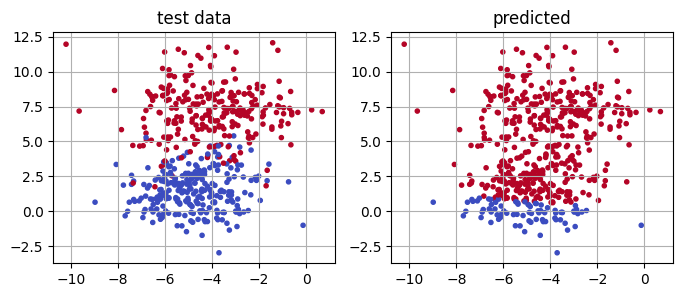

In [46]:
from sklearn.metrics import classification_report

predicted = model.predict(X_test)

print(classification_report( target_test, predicted) )

fig,ax = plt.subplots(1,2, figsize=(8,3),)
ax[0].scatter(x=X_test[:,0],y=X_test[:,1],c=target_test, marker='.', cmap='coolwarm')
ax[0].set_title('test data')
ax[0].grid()
ax[1].scatter(x=X_test[:,0],y=X_test[:,1],c=predicted, marker='.', cmap='coolwarm')
ax[1].set_title('predicted')
ax[1].grid()

взвешенное голосование AdaBoost 

$$
a(x) = sign \left( \sum_{i=1}^T w_i \cdot b_i(x) \right)
$$

In [64]:
class AdaBoostClassifier:
    
    def __init__( self, weight=np.array([]), base=[] ):
        assert len(weight)==len(base)
        #assert len(weight.shape)==2
        #assert weight.shape[1]==1
        #assert sum(weight)==1.
        
        self._weight = weight
        self._base = base
            
    def score(self,x):
        assert len(x)>0
        return np.vstack([ b.predict(x) for b in self._base ]).T.dot( self._weight )
    
    def predict(self,x): 
        return np.sign( self.score(x) ).astype(np.int8)  
   
    @property
    def weight(self): return self._weight

    #@weight.setter
    #def weight(self,value): self._weight = value
        
    @property
    def base(self): return self._base

    #@base.setter
    #def base(self,value): self._base = value
     
    def append(self,model,weight):
        self._base.append(model)
        if len(self._weight)>0:
            self._weight = np.vstack( [self._weight,[weight]] )
            self._weight = self._weight/self._weight.sum() 
        else:
            self._weight = np.array([[weight]])
            
        return self

In [65]:
# AdaBoostClassifier()

In [66]:
class TrainAdaBoost:
    
    def __init__(self,base,base_train,base_loss):
        self._base = base
        self._base_train = base_train
        self._base_loss = base_loss
        self._model = AdaBoostClassifier()
        
    def fit(self,X,target):
        assert len(X)>1
        assert len(X)==len(target)
        assert len(X.shape)==2
        assert len(target.shape)==2
        assert target.shape[1]==1
        
        n_samples = X.shape[0]
        d = 1./n_samples # добавка для расчёта веса компоненты на случай отсутствия ошибок 

        xweight = np.ones(shape=(n_samples,1))/n_samples
        
        _,model = self._base_train( model=self._base(),loss=self._base_loss() ).fit(X,target,xweight)
        
        o = model.predict(X)
            
        p = ((o*target>0)*xweight).sum() # сумма весов правильных ответов
        n = ((o*target<0)*xweight).sum() # сумма весов ошибочных ответов
        
         
        # базовый классификатор должен выдавать результат лучше чем случайный выбор 
        #if( n > .5 ): 
        #    print('step %i/%i: acc new stumb less 0.5\n'%(jj+1,n_epoch))
        #    break 
            #return model 
        
        
        a = np.log((p+d)/(n+d))/2. # вычисляем вес классификатора
    
        self._model.append(model,a)

#         loss_history.append(loss(X_train,rules,y_train)) # значение потери композиции
#         acc_history.append( accuracy_score( y_train,predict(X_train,rules)) ) # значение погрешности композиции
#         if acc_history[-1] > acc_min: # проверяем достижение минимального порога погрешности модели
#             print('step %i/%i: loss %.03f, acc threshold %.03f reached\n'%(jj+1,n_epoch,loss_history[-1],acc_min))
#             break

        # обновляем веса объектов
        xweight = xweight * np.exp( -a*target*o )
        xweight = xweight/xweight.sum()
        
        return self._model
        

In [67]:
 TrainAdaBoost(
     base=LinearClassifier,
     base_train=WeightedTrainGD,
     base_loss=WeightedLogLoss,
 ).fit(X_train,target_train)

In [68]:
# x = np.array([])
# np.hstack([x,[1]])

In [16]:
# model = LinearClassifier()
# model.copy()

In [ ]:
d = 1./n_samples # добавка для расчёта веса компоненты на случай отсутствия ошибок 

for jj in range(n_epoch):
    i,b,s = stumb_train(X_train,w,y_train) # обучаем базовый классификатор
    o = stumb(X_train,i,b,s) # ответ обученного базового классификатора
        
    p = ((o*y_train>0)*w).sum() # сумма весов правильных ответов
    n = ((o*y_train<0)*w).sum() # сумма весов ошибочных ответов
    # (o==0).sum() # количество отказов
    
    # базовый классификатор должен выдавать результат лучше чем случайный выбор 
    if( n > .5 ): 
        print('step %i/%i: acc new stumb less 0.5\n'%(jj+1,n_epoch))
        break 
      
    a = np.log((p+d)/(n+d))/2. # вычисляем вес классификатора
    
    rules.append([a,i,b,s]) # добавляем классификатор в композицию
     
    loss_history.append(loss(X_train,rules,y_train)) # значение потери композиции
    acc_history.append( accuracy_score( y_train,predict(X_train,rules)) ) # значение погрешности композиции
    if acc_history[-1] > acc_min: # проверяем достижение минимального порога погрешности модели
        print('step %i/%i: loss %.03f, acc threshold %.03f reached\n'%(jj+1,n_epoch,loss_history[-1],acc_min))
        break
        
    # обновляем веса объектов
    w = w*np.exp( -a*y_train*o )
    w = w/w.sum()


# нормируем веса классификаторов
a_sum = sum([ r[0] for r in rules ])
rules = [ [a/a_sum,i,b,s] for a,i,b,s in rules ]

In [ ]:
# rng.randint(0,2), rng.normal()
# AdaBoostClassifier( 
#     weight=np.array([[.23,.77]]).T,
#     base=[
#         DecisionStumbClassifier(n_feature=0, threshold=0.3),
#         DecisionStumbClassifier(n_feature=1, threshold=-0.7),
#     ] 
# ).score(X_train)

In [ ]:
#     def predict(self,x): 
#         return np.sign( self.score(x) ).astype(np.int8)
    
#     def score(x,rules): 
#         return np.sum([ a*stumb(x,i,b,s) for a,i,b,s in rules ],axis=0)

#     # ответ композиции классификаторов rules для входа x
#     def predict(x,rules): 
#         return np.sign(score(x,rules))       

#     @property
#     def weight(self): return self._weight

#     @weight.setter
#     def weight(self,value): self._weight = value
        
#     def weight_init(self,n,scale=1e-7): 
#         self._weight = rng.normal(size=(n,1),scale=scale)
#         return self
   
#     def score_partial(self,x): # частные производные модели по её параметрам
#         return x
    

In [ ]:
    
    # пороговый классификатор отказами
    #    вход, номер признака, порог, знак классификатора [-1,0,1]
    def stumb(X,i,b,s): 
        return s*np.sign(X[:,i]-b)

    # взвешенная суммарная ошибка классификатора h
    def err_count(X,i,b,s,w,y): 
        o = stumb(X,i,b,s) # ответ классификатора
        r = o*y<0 # ответ ошибочный и не отказ (!=0)
        return (r*w).sum() # взвешенная суммарная ошибка

    # разделение набора с наименьшей ошибкой
    #    вход, веса примеров, знак классификатора, метки примеров, количество порогов для выбора 
    def search_split(X,w,s,y,nb=30):
        # список порогов для каждого признака
        b = np.vstack([ np.linspace( X[:,i].min(), X[:,i].max(), nb )[1:-1] 
                        for i in range(X.shape[1]) ])

        # количество ошибок для разных признаков и значений порогов 
        err = np.array([ 
            [ err_count(X,i,b[i,j],s,w,y) for i in range(X.shape[1]) ]     
            for j in range(b.shape[1]) 
        ])

        # параметры с минимальным значением ошибок
        j,i = np.unravel_index(err.argmin(),err.shape)

        return i,b[i,j],err[j,i] # номер признака, порог, значение ошибки

    def stumb_train (X,w,y):
        # классификатор y=[x>b]
        i0,b0,err0 = search_split(X_train,w,1,y_train)
        # классификатор y=[x<b]
        i1,b1,err1 = search_split(X_train,w,-1,y_train)

        # выбираем классификатор с меньшей ошибкой
        i,b,s = (i0,b0,1) if (err0<err1) else (i1,b1,-1)

        return i,b,s

 

In [ ]:
# # пороговый классификатор отказами
# #    вход, номер признака, порог, знак классификатора [-1,0,1]
# def stumb(X,i,b,s): 
#     return s*np.sign(X[:,i]-b)

In [ ]:
# # взвешенная суммарная ошибка классификатора h
# def err_count(X,i,b,s,w,y): 
#     o = stumb(X,i,b,s) # ответ классификатора
#     r = o*y<0 # ответ ошибочный и не отказ (!=0)
#     return (r*w).sum() # взвешенная суммарная ошибка

# # разделение набора с наименьшей ошибкой
# #    вход, веса примеров, знак классификатора, метки примеров, количество порогов для выбора 
# def search_split(X,w,s,y,nb=30):
#     # список порогов для каждого признака
#     b = np.vstack([ np.linspace( X[:,i].min(), X[:,i].max(), nb )[1:-1] 
#                     for i in range(X.shape[1]) ])
    
#     # количество ошибок для разных признаков и значений порогов 
#     err = np.array([ 
#         [ err_count(X,i,b[i,j],s,w,y) for i in range(X.shape[1]) ]     
#         for j in range(b.shape[1]) 
#     ])
    
#     # параметры с минимальным значением ошибок
#     j,i = np.unravel_index(err.argmin(),err.shape)

#     return i,b[i,j],err[j,i] # номер признака, порог, значение ошибки

# def stumb_train (X,w,y):
#     # классификатор y=[x>b]
#     i0,b0,err0 = search_split(X_train,w,1,y_train)
#     # классификатор y=[x<b]
#     i1,b1,err1 = search_split(X_train,w,-1,y_train)
    
#     # выбираем классификатор с меньшей ошибкой
#     i,b,s = (i0,b0,1) if (err0<err1) else (i1,b1,-1)
    
#     return i,b,s

In [ ]:
# def score(x,rules): 
#     return np.sum([ a*stumb(x,i,b,s) for a,i,b,s in rules ],axis=0)

# # ответ композиции классификаторов rules для входа x
# def predict(x,rules): 
#     return np.sign(score(x,rules))

In [ ]:
# # значение ф-ции потери для композиции классификаторов r для входа X и меток y
# def loss(x,rules,y): 
#     return np.exp(-y* score(x,rules) ).sum()/len(y)

---

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
n_samples = len(y_train) # количество примеров
n_epoch = 200 # максимальное число циклов обучения
acc_min = .98 # порог минимально допустимой погрешности модели
n_param = X_train.shape[1] # размер вектора признаков

In [ ]:
# веса объектов учебной выборки
w = np.ones(n_samples)/n_samples
rules = [] # параметры классификаторов композиции
# ERR_BOUND=0.07 # порог ошибки

In [ ]:
# начальное значение ф-ции потери
loss_history = []
acc_history = []

In [ ]:
d = 1./n_samples # добавка для расчёта веса компоненты на случай отсутствия ошибок 

for jj in range(n_epoch):
    i,b,s = stumb_train(X_train,w,y_train) # обучаем базовый классификатор
    o = stumb(X_train,i,b,s) # ответ обученного базового классификатора
        
    p = ((o*y_train>0)*w).sum() # сумма весов правильных ответов
    n = ((o*y_train<0)*w).sum() # сумма весов ошибочных ответов
    # (o==0).sum() # количество отказов
    
    # базовый классификатор должен выдавать результат лучше чем случайный выбор 
    if( n > .5 ): 
        print('step %i/%i: acc new stumb less 0.5\n'%(jj+1,n_epoch))
        break 
      
    a = np.log((p+d)/(n+d))/2. # вычисляем вес классификатора
    
    rules.append([a,i,b,s]) # добавляем классификатор в композицию
     
    loss_history.append(loss(X_train,rules,y_train)) # значение потери композиции
    acc_history.append( accuracy_score( y_train,predict(X_train,rules)) ) # значение погрешности композиции
    if acc_history[-1] > acc_min: # проверяем достижение минимального порога погрешности модели
        print('step %i/%i: loss %.03f, acc threshold %.03f reached\n'%(jj+1,n_epoch,loss_history[-1],acc_min))
        break
        
    # обновляем веса объектов
    w = w*np.exp( -a*y_train*o )
    w = w/w.sum()


In [ ]:
# нормируем веса классификаторов
a_sum = sum([ r[0] for r in rules ])
rules = [ [a/a_sum,i,b,s] for a,i,b,s in rules ]

In [ ]:
# история изменения значений погрешности модели
plt.plot(acc_history,label='max acc=%.3f'%(max(acc_history)),c='r')
plt.grid()
plt.legend()

In [ ]:
# история изменения значений ф-ции потери
plt.plot(loss_history,label='min loss=%.3f'%(min(loss_history)))
plt.grid()
plt.legend()

----

# тестируем модель

In [ ]:
from sklearn.metrics import classification_report

predicted =  model.predict(poly.transform(X_test))
print(classification_report( target_test, predicted) )

fig,ax = plt.subplots(1,2, figsize=(8,3),)
ax[0].scatter(x=X_test[:,0],y=X_test[:,1],c=target_test, marker='.', cmap='coolwarm')
ax[0].grid()
ax[1].scatter(x=X_test[:,0],y=X_test[:,1],c=predicted, marker='.', cmap='coolwarm')
ax[1].grid()

In [ ]:
from sklearn.metrics import RocCurveDisplay

score = model.score(poly.transform(X_test))

fig,ax = plt.subplots( figsize=(6,5),)
RocCurveDisplay.from_predictions( target_test, score, name='class 1', color='darkorange', ax=ax )
ax.plot([0,1],[0,1], color='navy', lw=1, linestyle='--')
ax.grid()

## карта скоров

In [ ]:
# строим сетку 

n = 50 # количество разбиений сетки

xx,yy = np.meshgrid(
    np.linspace( X_test[:,0].min()-0.1, X_test[:,0].max()+0.1, n), 
    np.linspace( X_test[:,1].min()-0.1, X_test[:,1].max()+0.1, n)
) # узлы сетки
display( ( xx.shape, yy.shape ) )

xy = np.vstack([xx.ravel(),yy.ravel() ]).T # разворачиваем сетку 
display( xy.shape )

# plt.figure(figsize=(7,7))
# plt.scatter( x=xy[:,0], y=xy[:,1], s=1 )
# plt.show()

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# вычисляем скор для каждого узла сетки
score_xy = model.score(poly.transform(xy))
score_xy = MinMaxScaler(feature_range=(0.,1.)).fit_transform( score_xy )
score_xy = score_xy.reshape(n,n) 

In [ ]:
from matplotlib.colors import ListedColormap
fig,ax = plt.subplots(figsize=(6,4),sharey=True)
ax.contourf(xx, yy, score_xy )
ax.scatter( x=X_test[:,0], y=X_test[:,1], c=target_test, alpha=.5, s=5,  cmap='coolwarm' )
#ax[0].grid()

In [ ]:
# вычисляем скор для каждого узла сетки
predict_xy = model.predict(poly.transform(xy)).reshape(n,n) 

fig,ax = plt.subplots(figsize=(6,4),sharey=True)
ax.contourf(xx, yy, predict_xy, cmap=ListedColormap(['#0d1','#ee0']) )
ax.scatter( x=X_test[:,0], y=X_test[:,1], c=target_test, alpha=.5, s=5,  cmap='coolwarm' )

----

In [ ]:
## тестируем модель

In [ ]:
# s = score(X_test,rules)

In [ ]:
# from sklearn.metrics import roc_curve
# from sklearn.metrics import auc

# fpr, tpr, thresholds = roc_curve( y_test, s )
# roc_auc = auc(fpr,tpr)

# plt.figure(figsize=(7,7))
# plt.grid(True)
# plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC AUC %0.2f' % roc_auc)
# plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver operating characteristic')
# plt.legend(loc="lower right")
# plt.show()

In [ ]:
# # оптимальный порого скора 
# #  максимальное количество True Positive при минимальном количестве False Positive
# optimal_threshold = thresholds[ np.argmax( np.abs(tpr-fpr) )  ]
# optimal_threshold

In [ ]:
# p = (s>optimal_threshold).astype(int)
# y = (y_test>0).astype(int)

In [ ]:
# fig, (ax0,ax1) = plt.subplots(1,2, sharey=True, sharex=True, figsize=(12,5),)
# plot_data(ax0,X_test,y,'тестовые')    
# plot_data(ax1,X_test,p,'результат')    
# plt.show()

In [ ]:
# from sklearn.metrics import classification_report
# print(classification_report(y,p))

In [ ]:
## карта скоров

In [ ]:
# # строим сетку и определяем значения скора классификатора во всех узлах

# n=50 # количество разбиений сетки

# xx,yy = np.meshgrid(
#     np.linspace( X_test[:,0].min()-0.1, X_test[:,0].max()+0.1, n), 
#     np.linspace( X_test[:,1].min()-0.1, X_test[:,1].max()+0.1, n)
# ) # узлы сетки

# xy = np.vstack([xx.ravel(),yy.ravel() ]).T # разворачиваем сетку 

# s = score(xy,rules)

# plt.figure(figsize=(7,7))
# plt.contourf(xx, yy, (1.-s).reshape(n,n), cmap=plt.cm.RdBu)
# plt.scatter( x=X_test[:,0], y=X_test[:,1], c=y_test, alpha=.5 )
# plt.grid()

----

пороговый классификатор отказами

$$
a(x) = sign \left( x - t \right)
$$

In [ ]:
# class DecisionStumbClassifier:
    
#     def __init__( self, n_feature=0, threshold=0. ):
#         self._threshold = threshold # порог значения
#         self._n_feature = n_feature # номер признака
    
#     def score(self,x): 
#         assert len(x)>0
#         assert len(x.shape)==2
#         return x[:,[self._n_feature]] - self._threshold
    
#     def predict(self,x): 
#         return np.sign( self.score(x) ).astype(np.int8)
    
#     @property
#     def threshold(self): return self._threshold

#     @threshold.setter
#     def threshold(self,value): self._threshold = value    
        
#     @property
#     def n_feature(self): return self._n_feature

#     @n_feature.setter
#     def n_feature(self,value): self._n_feature = value            

In [ ]:
# DecisionStumbClassifier().predict(X_train)

In [ ]:
# max_value = np.abs(X_train).max(axis=0)
# display(max_value)
# np.linspace( start=-max_value, stop=max_value, num=n_thresholds+2 )[1:-1,:]

In [ ]:
# class TrainDecisionStumbClassifier:
    
#     def __init__(self,model):
#         self._model = model

#     def fit(self,X,target,n_thresholds=256):
#         err = self._search_split(X,target,n_thresholds) 
#         return err, self._model
    
#     # поиск оптимальной гиперплоскости 
#     def _search_split(self,X,target,n_thresholds): # n_thresholds - количество порогов для перебора
#         # min и max для каждого признака
#         # mm = np.vstack([X.min(axis=0), X.max(axis=0),]).T
#         # список порогов для каждого признака
#         #thresholds = np.linspace( start=mm[:,0], stop=mm[:,1], num=n_thresholds+2 )[1:-1,:]

#         max_value = np.abs(X).max(axis=0)
#         thresholds = np.linspace( start=-max_value, stop=max_value, num=n_thresholds+2 )[1:-1,:]
        
#         n_features = X.shape[1] # размерность пространства, количество признаков
        
#         # оценка классификатора для каждого признака и порога 
#         errors = np.array([ 
#                 [ 
#                     self._criterium(
#                             X,target,
#                             n_feature=n_feature,
#                             threshold=thresholds[n_threshold,n_feature]
#                         ) 
#                     for n_feature in range(n_features)  
#                 ]
#                 for n_threshold in range(n_thresholds) 
#             ])

#         # индексы минимального значения в матрице ошибок
#         n_threshold,n_feature = np.unravel_index(errors.argmin(),errors.shape)

#         self._model.threshold = thresholds[n_threshold,n_feature]
#         self._model.n_feature = n_feature
        
#         return errors[n_threshold,n_feature]
        
#     def _criterium(self,x,target,n_feature,threshold):
#         return self._errors(x,target,n_feature,threshold).sum()
#         # return (r*w).sum() # взвешенная суммарная ошибка    

#     # ошибки классификатора
#     def _errors(self,x,target,n_feature,threshold):
#         self._model.threshold = threshold
#         self._model.n_feature = n_feature
#         o = self._model.predict(x) # ответ классификатора
#         return ((o*target)<0).astype(np.uint8) # ответ ошибочный и не отказ (!=0)

In [ ]:
# err,model = TrainDecisionStumbClassifier(model=DecisionStumbClassifier()).fit(X_train,target_train)
# display(err)
# display(( err, model.n_feature, model.threshold,) )

---

In [ ]:
#     # разделение набора с наименьшей ошибкой
#     #    вход, веса примеров, знак классификатора, метки примеров, количество порогов для выбора 
#     def search_split(X,w,s,y,nb=30):
#         # список порогов для каждого признака
#         b = np.vstack([ np.linspace( X[:,i].min(), X[:,i].max(), nb )[1:-1] 
#                         for i in range(X.shape[1]) ])

#         # количество ошибок для разных признаков и значений порогов 
#         err = np.array([ 
#             [ err_count(X,i,b[i,j],s,w,y) for i in range(X.shape[1]) ]     
#             for j in range(b.shape[1]) 
#         ])

#         # параметры с минимальным значением ошибок
#         j,i = np.unravel_index(err.argmin(),err.shape)

#         return i,b[i,j],err[j,i] # номер признака, порог, значение ошибки

#     def stumb_train (X,w,y):
#         # классификатор y=[x>b]
#         i0,b0,err0 = search_split(X_train,w,1,y_train)
#         # классификатор y=[x<b]
#         i1,b1,err1 = search_split(X_train,w,-1,y_train)

#         # выбираем классификатор с меньшей ошибкой
#         i,b,s = (i0,b0,1) if (err0<err1) else (i1,b1,-1)

#         return i,b,s

 

In [ ]:
# weight = np.array([[.5,.5]]).T
# base=[DecisionStumbClassifier(),DecisionStumbClassifier()] 

# s = np.vstack([ b.predict(X_train) for b in base ])

# weight.shape, s.shape

# # s.T.dot(weight)